#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Best model usage - Mini projects (Predicting neural activity)

## Import the relevant packages and functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from utils import load_it_data, RidgeCV
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet, resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
import pickle
from tqdm import tqdm
import copy

## Load the data

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

# Fine-tune ResNet50 for classification of the images

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    val_acc_history = []
    model = model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize the losses for this epoch
            loss = 0.0
            corrects = 0
            
            steps_per_epoch_train = len(dataloaders['train'])
            steps_per_epoch_val = len(dataloaders['val'])
            
            for stimulus, label in dataloaders[phase]:
                stimulus, label = stimulus.cuda(), label.cuda()

                # zero out the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass (compute training loss)
                    prediction = model(stimulus)
                    loss = criterion(prediction, label)
                    
                    _, preds = torch.max(prediction, 1)

                    # Backward pass (compute new gradients, update weights))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update the loss for this epoch
                loss += loss.item() * stimulus.size(0)
                corrects += torch.sum(preds == label.data)

            epoch_loss = loss / len(dataloaders[phase].dataset)
            epoch_acc = corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
# Parameters
num_classes = len(np.unique(objects_train))
BATCH_SIZE = 10
EPOCHS = 40
LR = 0.001 

feature_extract = False # to finetune the model

# Datasets and dataloaders
le = preprocessing.LabelEncoder()

dataset_train = TensorDataset(torch.tensor(stimulus_train), torch.tensor(le.fit_transform(objects_train)))
dataset_val = TensorDataset(torch.tensor(stimulus_val), torch.tensor(le.fit_transform(objects_val)))
dataset_test = TensorDataset(torch.tensor(stimulus_test))
dataloaders = {'train' : DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE), 
               'val' : DataLoader(dataset_val, batch_size=BATCH_SIZE)}
testDataLoader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [5]:
# Initialize and reshape the model
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
params_to_update = resnet.parameters()

# Create the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=LR, momentum=0.9)

In [6]:
# Fine-tune the model
resnet, _ = train_model(resnet, dataloaders, criterion, optimizer, num_epochs=EPOCHS)

Epoch 0/39
----------
train Loss: 0.0038 Acc: 0.1103
val Loss: 0.1015 Acc: 0.3750

Epoch 1/39
----------
train Loss: 0.0033 Acc: 0.5015
val Loss: 0.0208 Acc: 0.6701

Epoch 2/39
----------
train Loss: 0.0020 Acc: 0.7542
val Loss: 0.0081 Acc: 0.7847

Epoch 3/39
----------
train Loss: 0.0020 Acc: 0.8576
val Loss: 0.0053 Acc: 0.8403

Epoch 4/39
----------
train Loss: 0.0010 Acc: 0.9055
val Loss: 0.0091 Acc: 0.8750

Epoch 5/39
----------
train Loss: 0.0013 Acc: 0.9383
val Loss: 0.0016 Acc: 0.8993

Epoch 6/39
----------
train Loss: 0.0007 Acc: 0.9657
val Loss: 0.0042 Acc: 0.8958

Epoch 7/39
----------
train Loss: 0.0010 Acc: 0.9815
val Loss: 0.0024 Acc: 0.9201

Epoch 8/39
----------
train Loss: 0.0006 Acc: 0.9877
val Loss: 0.0036 Acc: 0.9201

Epoch 9/39
----------
train Loss: 0.0004 Acc: 0.9946
val Loss: 0.0045 Acc: 0.9167

Epoch 10/39
----------
train Loss: 0.0023 Acc: 0.9961
val Loss: 0.0019 Acc: 0.9340

Epoch 11/39
----------
train Loss: 0.0008 Acc: 0.9985
val Loss: 0.0010 Acc: 0.9306

Ep

# Extract the activations and predict the neural activity

In [7]:
def extract_activations(self, stimuli) :
    """extract the activations of the model for the given stimuli

    Args:
        model (model): model we want to extract the activations from
        stimuli (ndarray): input data of the processed image's pixels

    Returns:
        list of ndarray: list of activations for each stimulus
    """    
    activations = []
    for x in stimuli : 
        x = self.conv1(x.unsqueeze(0))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
    return activations

ResNet.extract_activations = extract_activations

In [8]:
# extract the activations of the layer 3 and apply PCA to store the first 1000PCs
resnet.eval()
activations_train = resnet.extract_activations(torch.tensor(stimulus_train).cuda()) 
pca = PCA(n_components=1000)
pca.fit(activations_train)

# Save the activations of the train, val and test set  
with open('layer3_train.pkl','wb') as f:
    pickle.dump(pca.transform(activations_train), f)
with open('layer3_test.pkl','wb') as f:
    pickle.dump(pca.transform(resnet.extract_activations(torch.tensor(stimulus_test).cuda())), f)



R2 score for layer 3 in function of the parameter alpha : 


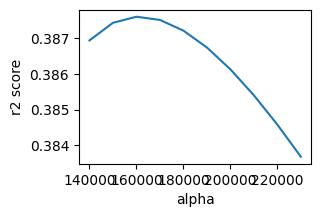

The best alpha is 160000


In [9]:
# Use the PCs of each layer to predict the neural activity using linear regression models
alphas = [140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000]

with open('layer3_train.pkl', 'rb') as f:
    activations_train = pickle.load(f)  
print('\n\nR2 score for layer 3 in function of the parameter alpha : ')
ridge, best_alphas = RidgeCV(activations_train, spikes_train, alphas)

# Make predictions

In [10]:
with open('layer3_test.pkl', 'rb') as f:
    activations_test = pickle.load(f)  

predictions = ridge.predict(activations_test)